[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/taobrienlbl/simple_dynamical_models/blob/main/Testing%20Simple%20Shallow%20Water.ipynb)


In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-poster')

C:\Users\travi\miniconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\travi\miniconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\travi\AppData\Local\Temp\ipykernel_19624\2047611777.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-poster')


This notebook implements and tests a numerical solution to the shallow water equations on a cartesian geometry, using 2nd order finite differences and a 4th-order Runge-Kutta solver for stepping forward in time.  Boundary conditions are implemented in a flexible way, allowing for periodicity in either dimension, flux-free boundary conditions, or numerically-specified boundary conditions via use of ghost cells.

The equation set solved follows Holton, Ch 3.1 equations SW.1--4:

$$\begin{eqnarray}
\frac{D\mathbf{u}}{dt} + \mathbf{f} \times \mathbf{u} & = & -g \nabla \eta \\
\frac{Dh}{dt} + h \nabla \cdot \mathbf{u} & = & 0 \\
h(x,y,t) & = & \eta(x,y,t) - \eta_b(x,y) \\
\frac{D}{Dt} & \equiv & \frac{\partial}{\partial t} + u \frac{\partial}{\partial x} + v \frac{\partial}{\partial y} \\
\end{eqnarray}$$


## Advection and boundary conditions

This section implements and tests advection, the boundary conditions, and the RK4 solver.

In [2]:

# define helper tuples for shifting data in the left, right, up, and down directions
# this is used for centered finite differences
c = 2*(slice(1,-1,None),)
l = (slice(1,-1,None), slice(None, -2, None))
r = (slice(1,-1,None), slice(2, None, None))
d = (slice(None, -2, None), slice(1, -1, None))
u = (slice(2, None, None), slice(1, -1, None))

def periodic_boundary(array, axis = -1):
    """ Implements a periodic boundary condition via ghost cells for the specified dimension """
    ndims = len(array.shape)
    slice_accessor_lhs = ndims*[slice(None,None,None)]
    slice_accessor_rhs = ndims*[slice(None,None,None)]
    
    # mirror the end of the array to the beginning
    slice_accessor_lhs[axis] = 0
    slice_accessor_rhs[axis] = -2 
    array[tuple(slice_accessor_lhs)] = array[tuple(slice_accessor_rhs)]
    
    # mirror the beginning of the array to the end
    slice_accessor_lhs[axis] = -1 
    slice_accessor_rhs[axis] = 1 
    array[tuple(slice_accessor_lhs)] = array[tuple(slice_accessor_rhs)]
    
    return

def advection_test_UV_tendency(state, eta, tendency_array, U_index = 1, V_index = 2):
    """ Returns zeros for the U/V tendencies; used for testing of advection """
    tendency_array[U_index,...] = 0.0
    tendency_array[V_index,...] = 0.0
    
    return
    
def cfd_h_sw1d_tendency(state, tendency_array, dx, dy, H_index = 0, U_index = 1, V_index = 2):
    """ sets the tendency for the height variable in the shallow-water system, calculated using 2nd-order finite differences. """
    # get pointers to the u,v, h and h tendency arrays
    U = state[U_index,:,:]
    V = state[V_index,:,:]
    H = state[H_index,:,:]
    dHdt = tendency_array[H_index,:,:]
    
    # it is assumed that boundary conditions are already loaded in the single layer of
    # ghost cells surrounding the state array
    
    # dhdt = -u * grad(h) - h * grad(u)
    dHdt[c] = \
        -U[c] * (H[r] - H[l])/(2*dx) \
        -V[c] * (H[u] - H[d])/(2*dy) \
        -H[c] * (U[r] - U[l])/(2*dx) \
        -H[c] * (V[u] - V[d])/(2*dy)
    
    # note that the above modifies a view of tendency_array, so no data need to be returned; the modification is in-place
    return

def cfd_uv_sw1d_tendency(state, eta, tendency_array, f, g, dx, dy, H_index = 0, U_index = 1, V_index = 2):
    """ sets the tendency for the u and v variables in the shallow-water system, calculated using 2nd-order finite differences. """
    # get pointers to the u,v, h and h tendency arrays
    U = state[U_index,:,:]
    V = state[V_index,:,:]
    H = state[H_index,:,:]
    dUdt = tendency_array[U_index,:,:]
    dVdt = tendency_array[V_index,:,:]
    
    # it is assumed that boundary conditions are already loaded in the single layer of
    # ghost cells surrounding the state array
    
    dx2 = 2*dx
    dy2 = 2*dy
    
    # dudt = -u * grad(u) + f * v - g * d_eta/dx
    dUdt[c] = \
        -U[c]*(U[r] - U[l])/dx2 \
        -V[c]*(U[u] - U[d])/dy2 \
        +f*V[c]                 \
        -g*(eta[r] - eta[l])/dx2
    
    # dvdt = -u * grad(v) - f * U - g * d_eta/dy
    dVdt[c] = \
        -U[c]*(V[r] - V[l])/dx2 \
        -V[c]*(V[u] - V[d])/dy2 \
        -f*U[c]                 \
        -g*(eta[u] - eta[d])/dy2
    
    # note that the above modifies a view of tendency_array, so no data need to be returned; the modification is in-place
    return
    
        
class SW1DSolver:
    
    def __init__(
        self,
        nx = 32,
        ny = 32,
        dx = 50e3,
        dy = 50e3,
        c_cfl = 30,
        cfl = 0.1,
        g = 9.806,
        f = 0, 
        eta_b = 0,
        x_is_periodic = True,
        y_is_periodic = True,
        array_type = np.float64,
        advection_testing = False,
        state0 = None,
        current_t = 0,
    ):
        """ Initialize the solver class; allocate variables, etc. """
        # store inputs
        self.nx = nx
        self.ny = ny
        self.dx = dx
        self.dy = dy
        self.c_cfl = c_cfl
        self.cfl = cfl
        self.g = g
        self.f = f
        self.eta_b = eta_b,
        self.x_is_periodic = x_is_periodic
        self.y_is_periodic = y_is_periodic
        self.array_type = array_type
        self.advection_testing = advection_testing
        self.current_t = current_t
        
        # initialize the state variables
        self.state_indices = dict(u = 0, v = 1, h = 2)
        self.num_state = len(self.state_indices)
        
        # allocate the state variable
        # (index 0 is the state variable, index 1 is y, index 2 is x)
        # Note that the dimension size is increased by 2 to account for ghost cells
        self._state_ = np.empty([self.num_state, ny+2, nx+2], dtype = array_type)
        if state0 is not None:
            # set the initial condition from what was passed in
            self._state_[:, 1:-1, 1:-1] = state0
            
            if not self.advection_testing:
                # set the CFL velocity based on the average fluid depth
                h_avg = np.mean(state0[self.state_indices['h'],:,:])
                # calculate the phase speed of typical gravity waves in this fluid
                self.c_cfl = np.sqrt(np.abs(self.g * h_avg))
            
        # determine the timestep
        self.dt = int(self.cfl * max([self.dx,self.dy]) / (self.c_cfl))
            
        # a temporary array for assisting in the RK4 solver
        self._solver_tmp_ = np.zeros([5,self.num_state, ny+2, nx+2], dtype = array_type)
        
        # a temporary array for the total height of the surface
        self._eta_tmp_ = np.zeros([ny+2, nx+2])
        
        # set the boundary condition callback function
        if x_is_periodic:
            self.x_boundary_function = lambda x: periodic_boundary(x, axis = -1)
        if y_is_periodic:
            self.y_boundary_function = lambda x: periodic_boundary(x, axis = -2)
            
        if advection_testing:
            # set the RHS for the u and v quantities such that they aren't updated
            self.uv_rhs_function = lambda state, eta, dstate_dt : \
                advection_test_UV_tendency(
                    state,
                    eta,
                    dstate_dt,
                    self.state_indices['u'],
                    self.state_indices['v'],
                )
        else:
            # set the RHS for u and v
            self.uv_rhs_function = lambda state, eta, dstate_dt : \
                cfd_uv_sw1d_tendency(
                    state,
                    eta,
                    dstate_dt,
                    self.f,
                    self.g,
                    self.dx,
                    self.dy,
                    H_index = self.state_indices['h'],
                    U_index = self.state_indices['u'],
                    V_index = self.state_indices['v'],
                )
            
        self.h_rhs_function = lambda state, dstate_dt : \
            cfd_h_sw1d_tendency(
                state,
                dstate_dt,
                self.dx,
                self.dy,
                H_index = self.state_indices['h'],
                U_index = self.state_indices['u'],
                V_index = self.state_indices['v'],
            )
        
        return
    
    def RHS(self, state, eta_b, dstate_dt):
        """ Updates dstate_dt with the right-hand side values of the 1D SW system. """
        
        # enforce the boundary conditions
        self.x_boundary_function(state)
        self.y_boundary_function(state)
        
        # update the total height field
        self._eta_tmp_[:] = state[self.state_indices['h'],:,:] + eta_b
        
        # update the U and V tendency variables;
        # this directly updates dstate_dt
        self.uv_rhs_function(state, self._eta_tmp_, dstate_dt)
        
        # update the h tendency
        # this directly updates dstate_dt
        self.h_rhs_function(state, dstate_dt)
        
     
    def step_forward(
        self,
        ndays = 5,
        state0 = None,
    ):
        """Steps the model forward a specified number of days; 
        uses the model's current state as the initial condition if one isn't given"""
        
        if state0 is not None:
            self._state_[:,1:-1,1:-1] = np.copy(np.array(state0))
            
            
        delta_t = ndays * 86400 # s
        tmax = self.current_t + delta_t
        dt = self.dt
        
        # pre-define some helper variables/views for the RK4 integration
        k1 = self._solver_tmp_[1,...]
        k2 = self._solver_tmp_[2,...]
        k3 = self._solver_tmp_[3,...]
        k4 = self._solver_tmp_[4,...]
        
        while self.current_t < tmax:
            # stage 1
            self.RHS(self._state_, self.eta_b, k1)
            
            # stage 2
            self._solver_tmp_[0,...] = self._state_ + k1 * dt/2
            self.RHS(self._solver_tmp_[0,...], self.eta_b, k2)
            
            # stage 3
            self._solver_tmp_[0,...] = self._state_ + k2 * dt/2
            self.RHS(self._solver_tmp_[0,...], self.eta_b, k3)
            
            # stage 4
            #print(self._state_.max(),k1.max(),k2.max(),k3.max(),k4.max())
            self._solver_tmp_[0,...] = self._state_ + k3 * dt
            self.RHS(self._solver_tmp_[0,...], self.eta_b, k4)
            
            # combine the tendencies into the final value
            self._state_[:] = \
                self._state_ + (1/6)*dt*(k1 + 2*k2 + 2*k3 + k4)
            
            # calculate the new time
            self.current_t += dt
            
    def get_state_xarray(self):
        """ Returns an xarray dataset containing the state variable. """
        
        x = np.arange(self.nx)*self.dx/1000
        x -= x.mean()
        y = np.arange(self.ny)*self.dy/1000
        y -= y.mean()
        t = np.array([self.current_t])
        
        out_ds = xr.Dataset()
        out_ds['time'] = xr.DataArray(t, dims = ['time'], coords = dict(time = t))
        out_ds['x'] = xr.DataArray(x, dims = ['x'], coords = dict(x = x))
        out_ds['y'] = xr.DataArray(y, dims = ['y'], coords = dict(y = y))
        
        out_ds['U'] = xr.DataArray(
            self._state_[self.state_indices['u'],:,:][c][np.newaxis,:,:],
            dims = ['time', 'y', 'x']
        )
        out_ds['V'] = xr.DataArray(
            self._state_[self.state_indices['v'],:,:][c][np.newaxis,:,:],
            dims = ['time', 'y', 'x']
        )
        out_ds['H'] = xr.DataArray(
            self._state_[self.state_indices['h'],:,:][c][np.newaxis,:,:],
            dims = ['time', 'y', 'x']
        )
        
        out_ds['time'].attrs['long_name'] = 'time'
        out_ds['time'].attrs['units'] = 'seconds since 1850-01-01 00:00:00'
        out_ds['x'].attrs['long_name'] = 'Zonal distance'
        out_ds['x'].attrs['units'] = 'km'
        out_ds['y'].attrs['long_name'] = 'Meridional distance'
        out_ds['y'].attrs['units'] = 'km'
        out_ds['U'].attrs['long_name'] = "Zonal wind"
        out_ds['U'].attrs['units'] = "m/s"
        out_ds['V'].attrs['long_name'] = "Meridional wind"
        out_ds['V'].attrs['units'] = "m/s"
        
        return out_ds
        
        
            
    

In [3]:
""" Test a: periodic boundaries """

nx = ny = 10
a = np.zeros([ny+2,nx+2])
a[c] = 1

# apply periodic boundaries in both the x- and y- directions
periodic_boundary(a, axis = -1)
periodic_boundary(a, axis = -2)

# expected result: array elements are 1 at the boundaries
assert np.all(a == 1)

In [4]:
""" Test 0: Instantiation """

test0 = SW1DSolver()

# expected result: no errors raised

In [5]:
""" Test 1: Run 1 step w/o breaking """
test1 = SW1DSolver(state0 = 0, advection_testing = True)
test1.RHS(test1._state_, 0, test1._solver_tmp_[0,...])

# expected result: no errors raised

In [6]:
""" Test 2: Run 1 step advection-only w/o breaking """
test2 = SW1DSolver(advection_testing=True, state0 = 1)
test2.RHS(test1._state_, 0, test1._solver_tmp_[0,...])

# expected result: no errors raised

In [7]:
""" Test 3: Run 1 day advection-only on uniform field """
state0 = 1 # initialize with all 1's
test3 = SW1DSolver(advection_testing=True, state0 = state0)

test3.step_forward(ndays = 1)

# expected result: initial field is identical to final field
assert np.all(test3._state_[:,1:-1,1:-1] == state0)

In [8]:
""" Test 4: Run 1 step advection-only on a non-uniform field """
# set the initial condition to be a bell
nx = ny = 101
dx = dy = 50e3
s_b = 5
a_b = 10
cx = (nx-1)/2
cy = (ny-1)/2
x = np.arange(nx)
y = np.arange(ny)
x, y = np.meshgrid(x,y)
test4 = SW1DSolver(
    nx = nx, ny = ny, dx = dx, dy = dy,
    advection_testing=True, state0 = 0)

# set the wind speed
U0 = 10 # m/s

state0 = np.array(test4._state_[:,1:-1, 1:-1], copy = True)
state0[test4.state_indices['h'],...] = \
    a_b * np.exp(-((x - cx)**2 + (y - cy)**2)/(4*(s_b**2)))
state0[test4.state_indices['u'],...] = U0 

test4.step_forward(ndays = test4.dt/86400, state0 = state0)

# expected result: final field differs from initial field
assert np.logical_not(np.all(test4._state_[:,1:-1,1:-1] == state0))

In [9]:
""" Test 5: Advect a full cycle with a horizontal periodic boundary condition """
# set the initial condition to be a bell
nx = ny = 101
dx = dy = 50e3
s_b = 10 
a_b = 10
cx = (nx-1)/2
cy = (ny-1)/2
x = np.arange(nx)
y = np.arange(ny)
x, y = np.meshgrid(x,y)
test5 = SW1DSolver(
    nx = nx, ny = ny, dx = dx, dy = dy,
    advection_testing=True, state0 = 0)

# set the wind speed
U0 = 10 # m/s

state0 = np.array(test5._state_[:,1:-1, 1:-1], copy = True)
state0[test5.state_indices['h'],...] = \
    a_b * np.exp(-((x - cx)**2 + (y - cy)**2)/(4*(s_b**2)))
# advect diagonally at a total speed of U0
state0[test5.state_indices['u'],...] = U0 *np.sqrt(2)/2
state0[test5.state_indices['v'],...] = U0 *np.sqrt(2)/2

# calculate the time required for one full transit
x_domain = np.sqrt((nx * dx)**2 + (ny * dy)**2)
t_transit = x_domain / U0

# adjust dt so we can do exactly one full transit
n_transit = int(t_transit/test5.dt)
test5.dt = t_transit / n_transit

test5.step_forward(ndays = t_transit/86400, state0 = state0)

# calculate the mean squared error
MSE = np.sqrt(np.mean((state0[2,...]-test5._state_[2,...][c])**2))

# expected result: mean squared error is small
assert MSE < 0.05

In [10]:
""" Test 6: symmetric, geostrophically-balanced zonal jets """
# set the initial condition to be a bell
nx = ny = 101
dx = dy = 50e3
s_b = 5 
a_b = 10
h0 = 5e3 # m
u0 = 30 # m/s
cx = (nx-1)/2
cy = (ny-1)/2
x = np.arange(nx)
y = np.arange(ny)
x, y = np.meshgrid(x,y)
eta_b = 0 # m
f = 1e-5 # 1/s
g = 9.806 # m/s/s

# make a zonal jet
state0 = np.zeros([3,ny,nx])
state0[0,...] = \
      u0 * np.exp(-(y - (cy + cy/2))**2/(2*s_b**2)) \
    - u0 * np.exp(-(y - (cy - cy/2))**2/(2*s_b**2))

#state0[1,...] = \
#      u0 * np.exp(-(x - (cx + cx/2))**2/(2*s_b**2)) \
#    - u0 * np.exp(-(x - (cx - cx/2))**2/(2*s_b**2))

# calculate the geostrophically-balanced height field
state0[2,...] = h0
for i in range(-1,ny-2):
    state0[2,i+2,:] = state0[2,i,:] - (2*dy*f/g)*state0[0,i+1,:]
for j in range(-1,nx-2):
    state0[2,:,j+2] = state0[2,:,j] + (2*dx*f/g)*state0[1,:,j+1]

test6 = SW1DSolver(
    nx = nx, ny = ny, dx = dx, dy = dy,
    f = f, eta_b = eta_b, g = g,
    advection_testing=False, state0 = state0)

test6.step_forward(ndays = 1*test6.dt/86400, state0 = state0)


assert np.all(np.isclose(test6._state_[:,1:-1,1:-1],state0))

In [11]:
""" Test 7: symmetric, geostrophically-balanced meridional jets """
# set the initial condition to be a bell
nx = ny = 101
dx = dy = 50e3
s_b = 5 
a_b = 10
h0 = 5e3 # m
u0 = 30 # m/s
cx = (nx-1)/2
cy = (ny-1)/2
x = np.arange(nx)
y = np.arange(ny)
x, y = np.meshgrid(x,y)
eta_b = 0 # m
f = 1e-5 # 1/s
g = 9.806 # m/s/s

# make a meridional jet
state0 = np.zeros([3,ny,nx])
state0[1,...] = \
      u0 * np.exp(-(x - (cx + cx/2))**2/(2*s_b**2)) \
    - u0 * np.exp(-(x - (cx - cx/2))**2/(2*s_b**2))

# calculate the geostrophically-balanced height field
state0[2,...] = h0
for i in range(-1,ny-2):
    state0[2,i+2,:] = state0[2,i,:] - (2*dy*f/g)*state0[0,i+1,:]
for j in range(-1,nx-2):
    state0[2,:,j+2] = state0[2,:,j] + (2*dx*f/g)*state0[1,:,j+1]

test7 = SW1DSolver(
    nx = nx, ny = ny, dx = dx, dy = dy,
    f = f, eta_b = eta_b, g = g,
    advection_testing=False, state0 = state0)

test7.step_forward(ndays = 1*test7.dt/86400, state0 = state0)


assert np.all(np.isclose(test7._state_[:,1:-1,1:-1],state0))

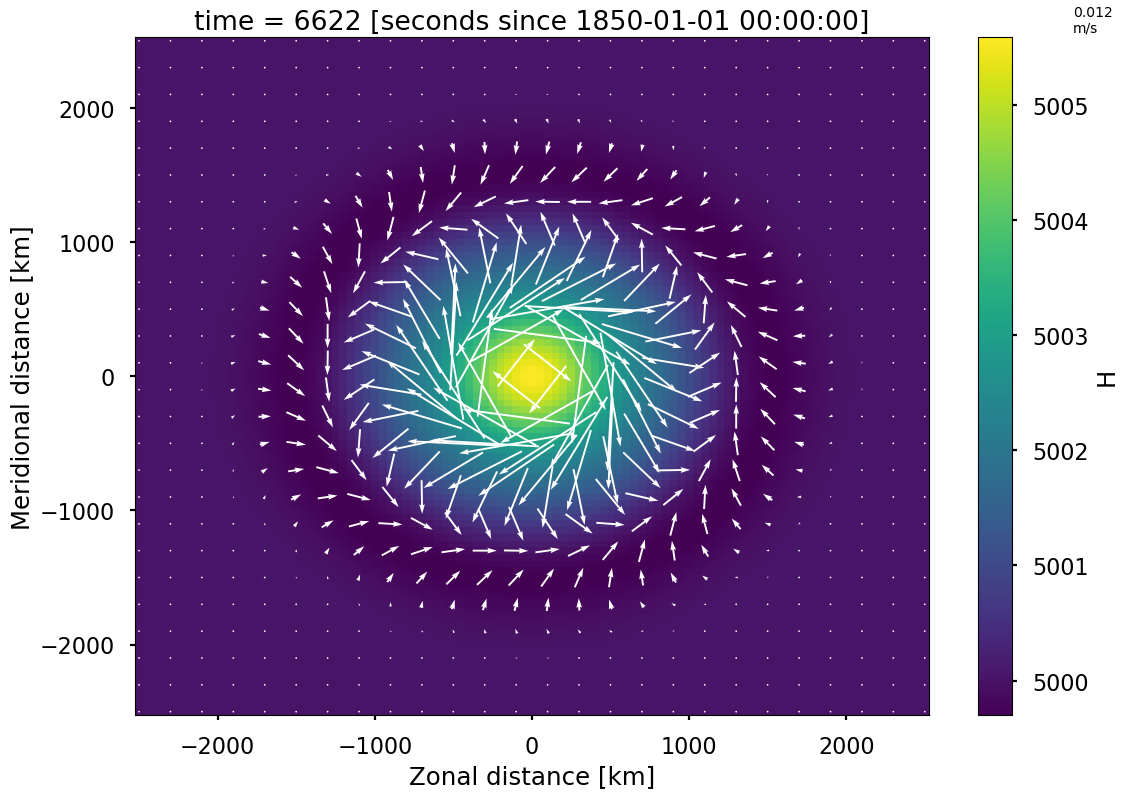

In [12]:
""" Test 8: The bell drop """
# set the initial condition to be a bell
nx = ny = 101
dx = dy = 50e3
s_b = 5 
a_b = 10
h0 = 5e3
cx = (nx-1)/2
cy = (ny-1)/2
x = np.arange(nx)
y = np.arange(ny)
x, y = np.meshgrid(x,y)

state0 = np.zeros([3,ny,nx])
state0[2,...] = \
    h0 + a_b * np.exp(-((x - cx)**2 + (y - cy)**2)/(4*(s_b**2)))

test8 = SW1DSolver(
    nx = nx, ny = ny, dx = dx, dy = dy,
    f = 1e-3,
    advection_testing=False, state0 = state0)

test8.step_forward(ndays = 300*test8.dt/86400, state0 = state0)

test8_ds = test8.get_state_xarray().squeeze()


fig, ax = plt.subplots()
test8_ds['H'].plot(ax = ax)
test8_ds.sel(x = slice(None,None, 4), y = slice(None,None,4)).plot.quiver('x','y','U','V',color = 'white')
plt.show()